In [1]:
import sys
import glob
import os, os.path
import subprocess
import xarray as xr
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

# Define ice extent

In [48]:
INPUT_FILENAME='thk_DST.nc' # File produced by "remap_cism.sh"

In [49]:
ds = xr.open_dataset(INPUT_FILENAME)

In [50]:
ds.load()

<xarray.Dataset>
Dimensions:   (nv4: 4, time: 1, x: 1496, y: 2700)
Coordinates:
    lon       (y, x) float64 -55.79 -55.77 -55.76 -55.74 -55.72 -55.71 ...
    lat       (y, x) float64 59.2 59.21 59.21 59.21 59.21 59.21 59.21 59.22 ...
  * time      (time) float64 0.0
Dimensions without coordinates: nv4, x, y
Data variables:
    lon_bnds  (y, x, nv4) float64 -55.8 -55.78 -55.78 -55.8 -55.78 -55.76 ...
    lat_bnds  (y, x, nv4) float64 59.2 59.2 59.21 59.21 59.2 59.2 59.21 ...
    thk       (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
Attributes:
    CDI:               Climate Data Interface version 1.7.2 (http://mpimet.mp...
    Conventions:       CF-1.3
    history:           Fri Oct 19 02:09:11 2018: cdo remapbil,/gpfs/u/home/lv...
    cesmYMD:           19800101
    cesmTOD:           0
    glcYMD:            19800101
    glcTOD:            0
    elapsed_days:      365
    time_period_freq:  year_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    CDO:  

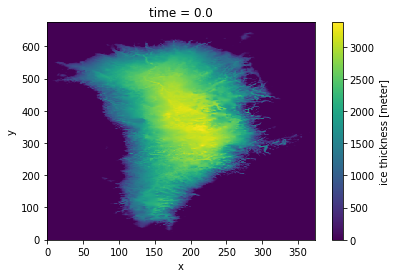

In [51]:
ds['thk'][0,::4,::4].plot()

In [52]:
ds['extent'] = xr.where(ds['thk'] > 1, 1.0, 0.0)

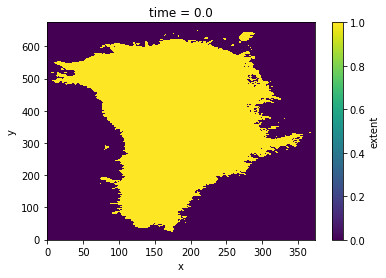

In [53]:
ds['extent'][:,::4,::4].plot()

# Drop thickness

In [54]:
ds = ds.drop('thk')

# Attributes

In [67]:
attrs = ds['extent'].attrs
attrs['long_name'] = 'Ice extent based on CISM thickness map'
attrs['units'] = 'fraction'

attrs = ds.attrs
attrs['institution'] ="NCAR and Utrecht University"
attrs['contact'] = "L.vankampenhout@uu.nl"
attrs['model'] = "CESM 2.0 in atmosphere only mode"
attrs['comment'] = "Topography SRF_GIMP was assumed in the downscaling procedure"

# Add surface topography

In [56]:
ds2 = xr.open_dataset('/gpfs/p/work/lvank/SMBmip/MARv3.9-yearly-ERA-Interim-1980.nc', decode_times=False)

In [61]:
ds['SRF_GIMP'] = ds2['SRF_GIMP']

In [62]:
ds.load()

<xarray.Dataset>
Dimensions:   (nv4: 4, time: 1, x: 1496, y: 2700)
Coordinates:
  * y         (y) float32 5.0 10.0 15.0 20.0 25.0 30.0 35.0 40.0 45.0 50.0 ...
  * x         (x) float32 5.0 10.0 15.0 20.0 25.0 30.0 35.0 40.0 45.0 50.0 ...
    lon       (y, x) float64 -55.79 -55.77 -55.76 -55.74 -55.72 -55.71 ...
    lat       (y, x) float64 59.2 59.21 59.21 59.21 59.21 59.21 59.21 59.22 ...
  * time      (time) float64 0.0
Dimensions without coordinates: nv4
Data variables:
    lon_bnds  (y, x, nv4) float64 -55.8 -55.78 -55.78 -55.8 -55.78 -55.76 ...
    lat_bnds  (y, x, nv4) float64 59.2 59.2 59.21 59.21 59.2 59.2 59.21 ...
    extent    (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    SRF_GIMP  (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
Attributes:
    CDI:               Climate Data Interface version 1.7.2 (http://mpimet.mp...
    Conventions:       CF-1.3
    history:           Fri Oct 19 02:09:11 2018: cdo remapbil,/gpfs/u/home/lv...
    

# Save output

In [58]:
ds.data_vars.keys()

KeysView(Data variables:
    lon_bnds  (y, x, nv4) float64 -55.8 -55.78 -55.78 -55.8 -55.78 -55.76 ...
    lat_bnds  (y, x, nv4) float64 59.2 59.2 59.21 59.21 59.2 59.2 59.21 ...
    extent    (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    SRF_GIMP  (y, x) float32 ...)

In [66]:
outfile = "metadata_CESM_uncompressed.nc"

ds.to_netcdf(outfile) # no compression b/c that is very slow. Can add it later with CDO. 
             
#ds.to_netcdf(outfile, 
#        encoding={
#            varname: {'zlib': True, 'complevel': 9} for varname in (list(ds.data_vars.keys()) + ['lat','lon'])
#        })   

/glade/work/bitz/miniconda3/envs/pangeo/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
